In [37]:
import ase.io
import torch

import metatensor.torch as mts
from metatensor.torch import TensorMap, Labels, TensorBlock

dtype = torch.float64

frames = ase.io.read("metatrain_samples.xyz", ":")
ase.io.write("frames.xyz", frames, format="xyz")

dos_values = torch.vstack(
    [
        torch.tensor(frame.info["DOS"], dtype=dtype) * len(frame)
        for frame in frames
    ]
)
n_pad = 200
dos_values = torch.hstack([torch.zeros(dos_values.shape[0], n_pad), dos_values[:, :-200]])

# Create the mask for the DOS based on NaN
mask_values = torch.isnan(dos_values)
mask_values = mask_values.to(torch.bool)

# Now replace NaNs with zeros
dos_values = torch.where(mask_values, torch.zeros_like(dos_values), dos_values)

dos = TensorMap(
    Labels(["_"], torch.tensor([[0]])),
    [
        TensorBlock(
            samples=Labels(["system"], torch.tensor([[A] for A in range(len(frames))])),
            components=[],
            properties=Labels(["energy"], torch.arange(dos_values.shape[1]).reshape(-1, 1)),
            values=dos_values,
        )
    ]
)
dos_mask = TensorMap(
    Labels(["_"], torch.tensor([[0]])),
    [
        TensorBlock(
            samples=Labels(["system"], torch.tensor([[A] for A in range(len(frames))])),
            components=[],
            properties=Labels(["energy"], torch.arange(dos_values.shape[1]).reshape(-1, 1)),
            values=(~mask_values).to(torch.float64),
        )
    ]
)
mts.save("dos.mts", dos)
mts.save("dos_mask.mts", dos_mask)

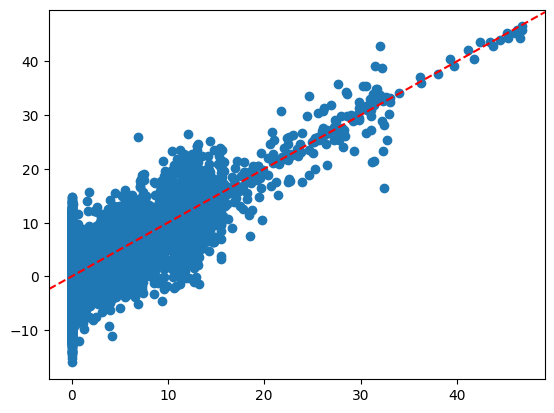

In [38]:
import ase.io
import torch
import matplotlib.pyplot as plt

import metatensor.torch as mts

from metatomic.torch import NeighborListOptions, systems_to_torch, ModelOutput, ModelEvaluationOptions
from metatrain.utils.neighbor_lists import get_system_with_neighbor_lists
from metatrain.utils.io import load_model

dtype = torch.float32

frames = ase.io.read("frames.xyz", ":")
dos = mts.load("dos.mts")
dos_mask = mts.load("dos_mask.mts").to(torch.bool)

systems = [
    get_system_with_neighbor_lists(
        systems_to_torch(frame, dtype=dtype),
        [NeighborListOptions(cutoff=5.0, full_list=True, strict=True)],
    )
    for frame in frames
]
outputs = ModelEvaluationOptions(
    length_unit="angstrom",
    outputs={
        "mtt::dos": ModelOutput(per_atom=False),
    },
)

model = load_model("model.pt")
predictions = model(systems, outputs, check_consistency=True)["mtt::dos"]

fig, ax = plt.subplots()
ax.scatter(
    dos[0].values[dos_mask[0].values],
    predictions[0].values[dos_mask[0].values],
)
ax.axline((0, 0), slope=1, color='red', linestyle='--')

In [80]:
targ = dos[0].values
pred = predictions[0].values
mask = dos_mask[0].values

targ_unpadded = targ[:, n_pad:]

pred_unfolded = pred.unfold(1, targ_unpadded.shape[1], 1)
targ_unpadded_expanded = targ_unpadded[:, None, :]


delta = targ_unpadded_expanded - pred_unfolded
delta_masked = delta * mask[:, n_pad:].unsqueeze(dim=1)

error_windows = torch.trapezoid(delta_masked**2, dx=0.05, dim=2)

# Now compute the error on the front tail using trapezoidal integration. As the left
# padding of the DOS targets is by definition zero, we just use the predictions here.
error_front_tail = torch.cumulative_trapezoid(pred[:, : n_pad + 1] ** 2, dx=0.05, dim=1)

# Account for the fact that the first window has no additional padding and therefore
# error
error_front_tail = torch.hstack([torch.zeros(error_front_tail.shape[0], 1), error_front_tail])

# Add the additional errors
total_errors = error_windows + error_front_tail

# Find the window with the minimum error
min_error_index = torch.argmin(total_errors, dim=1)
min_error_index

min_dos_error_per_structure, min_shifts = torch.min(total_errors, dim=1)

loss = min_dos_error_per_structure.mean()
loss
# targ[mask].reshape(targ.shape[0], -1).shape

tensor(1061.2593, dtype=torch.float64)